### First, the libraries i'm gonna use in this project

In [183]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.compose import ColumnTransformer

from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier

In [184]:
# reading the dataset of dating and marriage subreddits - generated in 'scraping'
date_marry = pd.read_csv('output/marriage_dating.csv')
date_marry.drop(columns = 'Unnamed: 0', inplace = True)

In [185]:
date_marry.head()

,title,self_text,subreddit
0,What does it mean when a girl says I don’t fee...,I had a date yesterday and I thought it was ok...,dating
1,why do some guys get hurt/bothered if you slee...,My ex recently found out I hooked up with some...,dating
2,Worst era to ever date in as a guy.,Is there a single (attractive) young woman (ea...,dating
3,"Why do some men hate ""Vanilla women""?","Hiya. Earlier today I got called a ""vanilla wo...",dating
4,Guys the Victim mentality WONT help you,I've been couple of years in this sub and that...,dating


In [186]:
date_marry.isna().sum()

title        0
self_text    0
subreddit    0
dtype: int64

In [187]:
# Changing subreddit column to numeric
# 'dating' is 1, 'marriage' is 0
date_marry['subreddit'] = (date_marry['subreddit']=='dating')*1

In [188]:
date_marry.head()

,title,self_text,subreddit
0,What does it mean when a girl says I don’t fee...,I had a date yesterday and I thought it was ok...,1
1,why do some guys get hurt/bothered if you slee...,My ex recently found out I hooked up with some...,1
2,Worst era to ever date in as a guy.,Is there a single (attractive) young woman (ea...,1
3,"Why do some men hate ""Vanilla women""?","Hiya. Earlier today I got called a ""vanilla wo...",1
4,Guys the Victim mentality WONT help you,I've been couple of years in this sub and that...,1


In [189]:
# Checking the size of the dataset
date_marry.shape

(7658, 3)

In [190]:
# Checking if there are duplicates
date_marry.drop_duplicates(inplace=True)
date_marry.shape

(7658, 3)

In [191]:
# Checking the baseline of the dataset
date_marry['subreddit'].value_counts(normalize=True)

1    0.599373
0    0.400627
Name: subreddit, dtype: float64

# Analyzing some specific words
Maybe the subreddits are a lot different and it is not that challenging to predict from which subreddit the post is... <br>
Let's explore some words that can be very specific to each one of the subreddits

In [192]:
husband = date_marry['title'].str.lower().str.contains('husband')
wife = date_marry['title'].str.lower().str.contains('wife')
wedding = date_marry['title'].str.lower().str.contains('wedding')
marry = date_marry['title'].str.lower().str.contains('marry')
date_marry['marriage_keywords'] = (husband | wife | wedding | marry)
date_marry['marriage_keywords'] = date_marry['marriage_keywords'].astype(int)

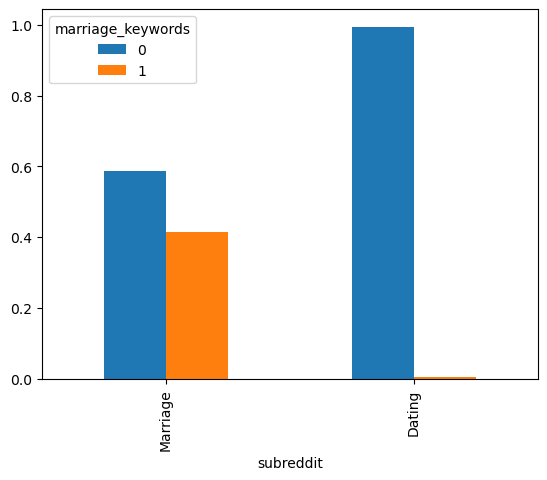

In [193]:
date_marry.groupby('subreddit')['marriage_keywords'].value_counts(normalize=True).unstack(level = 1).plot(kind = 'bar')
plt.xticks([0, 1], ['Marriage', 'Dating']);


From the graph above, it is possible to see that aproximately 40% of marriage subreddits have "husband", "wife", "wedding" or "marry" in the title, while almost 100% of the dating's subreddit titles do not mention these words. This could facilitate a lot the model to predict from which subreddit the post came from... first, let's see how the model performs. If it's too easy, maybe i'll make it more challenging by removing words that are too specific of the subreddits ;)

In [194]:
boyfriend = date_marry['title'].str.lower().str.contains('boyfriend')
girlfriend = date_marry['title'].str.lower().str.contains('girlfriend')
bf = date_marry['title'].str.lower().str.contains('bf')
gf = date_marry['title'].str.lower().str.contains('gf')
date_marry['dating_keywords'] = (boyfriend | girlfriend | bf | gf)
date_marry['dating_keywords'] = date_marry['dating_keywords'].astype(int)

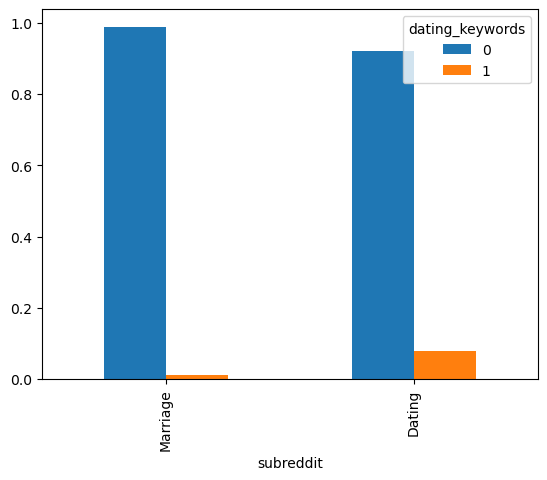

In [195]:
date_marry.groupby('subreddit')['dating_keywords'].value_counts(normalize=True).unstack(level = 1).plot(kind = 'bar')
plt.xticks([0, 1], ['Marriage', 'Dating']);

Boyfriend and girlfriend dont seem to be so much more present in dating's posts' description than in the marriage ones... <br>
Let's see if seeing the most common words for both of the subreddits give us the same insight

> # Most common words in marriage and dating

## Most common words, with stop words

In [196]:
# Redefine training and testing sets.
X = date_marry[date_marry['subreddit']==0]['self_text']
y = date_marry['subreddit']
cvec = CountVectorizer()

In [197]:
X = cvec.fit_transform(X)

Text(0.5, 1.0, 'Marriage most common words')

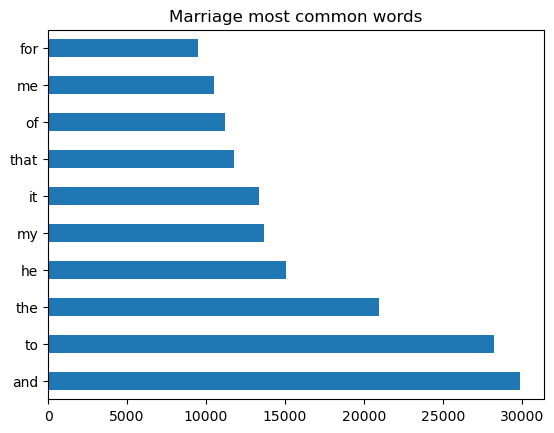

In [198]:
X_df = pd.DataFrame(X.todense(), columns = cvec.get_feature_names_out())
X_df.sum().sort_values(ascending=False)[:10].plot(kind='barh')
plt.title('Marriage most common words')

In [199]:
# Redefine training and testing sets.
X = date_marry[date_marry['subreddit']==1]['self_text']
y = date_marry['subreddit']
cvec = CountVectorizer()

In [200]:
X = cvec.fit_transform(X)

Text(0.5, 1.0, 'Dating most common words')

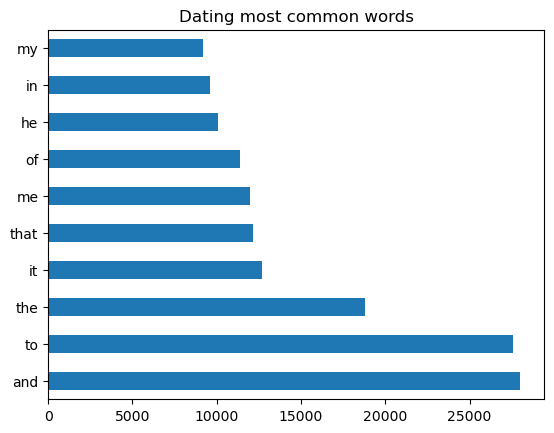

In [201]:
X_df = pd.DataFrame(X.todense(), columns = cvec.get_feature_names_out())
X_df.sum().sort_values(ascending=False)[:10].plot(kind='barh')
plt.title('Dating most common words')

Plotting the 10 most common words considering the stop words dont tell us much about the words too specific to each of the subreddits... maybe without the stop words we can see something

## Most common words, without stop words

In [202]:
# Redefine training and testing sets.
X = date_marry[date_marry['subreddit']==0]['self_text']
y = date_marry['subreddit']
cvec = CountVectorizer(stop_words='english')

In [203]:
X = cvec.fit_transform(X)

Text(0.5, 1.0, 'Marriage most common words')

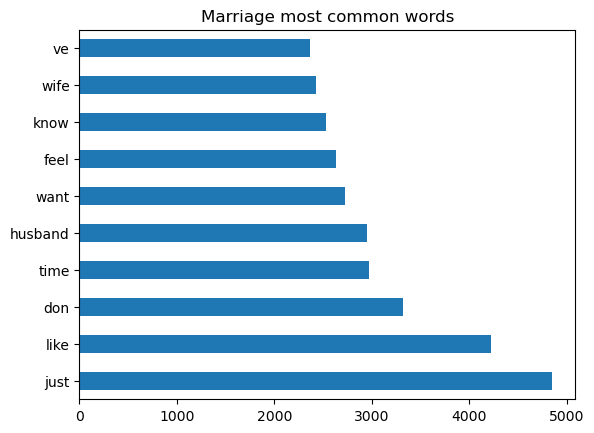

In [204]:
X_df = pd.DataFrame(X.todense(), columns = cvec.get_feature_names_out())
X_df.sum().sort_values(ascending=False)[:10].plot(kind='barh')
plt.title('Marriage most common words')

In [205]:
# Redefine training and testing sets.
X = date_marry[date_marry['subreddit']==1]['self_text']
y = date_marry['subreddit']
cvec = CountVectorizer(stop_words='english')

In [206]:
X = cvec.fit_transform(X)

Text(0.5, 1.0, 'Dating most common words')

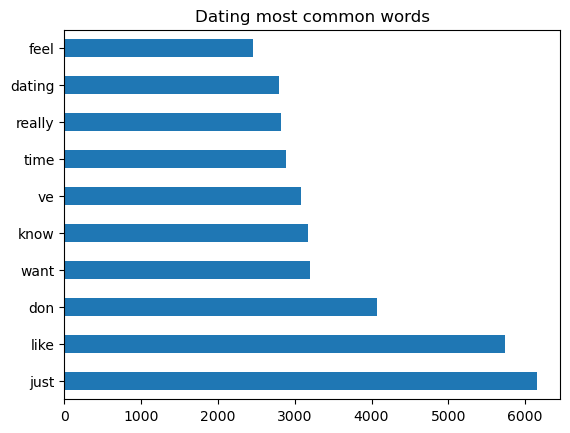

In [207]:
X_df = pd.DataFrame(X.todense(), columns = cvec.get_feature_names_out())
X_df.sum().sort_values(ascending=False)[:10].plot(kind='barh')
plt.title('Dating most common words')

When not considering stop words, two marriage keywords that were explored earlier in the barplots are actually in the top 10 most common words in marriage's posts' texts <br>
As mentioned above, after checking models' performances, maybe these will get removed to make it more challenging ;)

# Special characters - are there differences between subreddits?

### Counting special characters and checking if there are differences between subreddits

In [208]:
# code adapted from stack overflow
# https://stackoverflow.com/questions/59687650/how-to-count-special-chars-in-column-in-pandas
date_marry["special_characters"] = date_marry["self_text"].apply(lambda x: sum(not c.isalpha() for c in x ))
date_marry["special_characters"]

0        155
1         53
2         54
3        141
4        239
        ... 
7653     111
7654    1019
7655      14
7656     516
7657     117
Name: special_characters, Length: 7658, dtype: int64

In [209]:
date_marry.groupby('subreddit')['special_characters'].describe()

,count,mean,std,min,25%,50%,75%,max
subreddit,,,,,,,,
0,3068.0,338.818123,363.127990,0.0,115.75,242.0,441.0,4660.0
1,4590.0,227.426797,236.988225,8.0,82.00,161.0,292.0,4286.0


In [210]:
most_special_characters = date_marry[date_marry["special_characters"]==4660]['self_text']
for string in most_special_characters:
    print(string)

**Final Edit I promise!** 

*Don't worry y'all, I'll be a distant part of your short-term internet memory in like 12 hours.* 

*Trigger warning- the following portion will add another 300 words or so. If you're averse to reading long things, go to Twitter.* 

For those (there were a tiny few) who enjoyed my writing or my "candor," feel free to "follow" me on Reddit. I tend to fixate on a subject on Reddit about once a month, I write 2 to 3 pages on it, and then, typically, I get a mixture of temper tantrums, 'amen brothers' in my DMs, and angry people who read the first 25 words and assume they've read it all. 

For those who insisted on calling me names, using insulting adjectives, or (my least favorite) using all the vocab they learned in Berne Brown's TED Talk to psychoanalyze me while they are angrily typing away on their phones, what do you think your purpose was? Those of us who've (not proud of this) argued with trump supporters or AOC supporters or anti-vaxxers or steelers fans

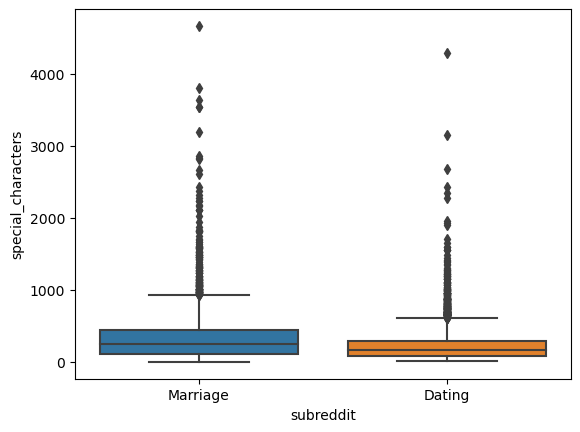

In [211]:
sns.boxplot(x="subreddit", y="special_characters",data=date_marry)
plt.xticks([0, 1], ['Marriage', 'Dating']);

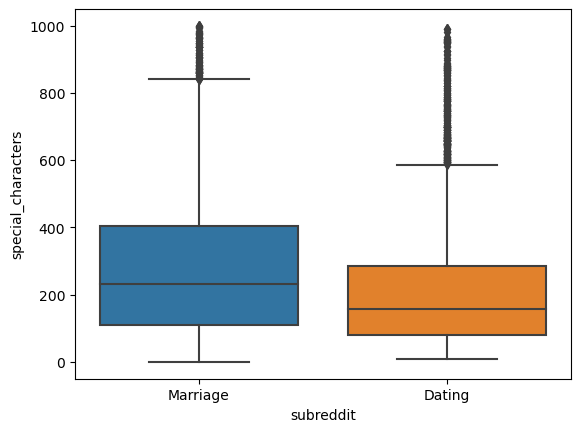

In [212]:
sns.boxplot(x="subreddit", y="special_characters",data=date_marry[date_marry['special_characters']<1000])
plt.xticks([0, 1], ['Marriage', 'Dating']);

It looks there is a difference of the number of special characters per posts between the subreddits... <br>
I'm gonna leave the new column with the number of character the posts' descriptions have, this may help the model

In [213]:
# splitting the dataset and applying count vectorizer to the posts' descriptions
X = date_marry['self_text']
y = date_marry['subreddit']
cvec = CountVectorizer()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1906)
X_train = cvec.fit_transform(X_train)
X_train.shape

(5743, 20963)

20963 columns were created applying count vectorizer in the posts' descriptions

In [214]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
logreg.score(X_train, y_train)

/Users/gabrielafichtner/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9961692495211562

In [215]:
X_test = cvec.transform(X_test)
logreg.score(X_test, y_test)

0.9195822454308094

# To remove or to not remove special characters?

Since there is already information on the special characters, special characters will be removed. Simplicity is improved, while posts' text content is maintained.

In [216]:
# Code adapted from chat gpt - asked for a regex to remove characters that werent letters and keep the space
date_marry['self_text'] = date_marry['self_text'].str.replace("’", "'", regex=True)
date_marry['self_text'] = date_marry['self_text'].str.replace(r'[^A-Za-z\s\']', ' ', regex=True)

In [217]:
date_marry['self_text']

0       I had a date yesterday and I thought it was ok...
1       My ex recently found out I hooked up with some...
2       Is there a single  attractive  young woman  ea...
3       Hiya  Earlier today I got called a  vanilla wo...
4       I've been couple of years in this sub and that...
                              ...                        
7653    \nWhat is the consensus when cheating happens ...
7654    I'm struggling and don't know what to do  Sorr...
7655    What do you do if you husband or wife became c...
7656    I'm      a teacher who is off during the summe...
7657    Occasionally  will take time off from work and...
Name: self_text, Length: 7658, dtype: object

In [218]:
date_marry[date_marry['self_text'].str.contains('%')]

,title,self_text,subreddit,marriage_keywords,dating_keywords,special_characters


# Getting the sentiment analysis of the posts' descriptions

In [219]:
# Creating the columns with the negative, positive, neutral and compound scores
sa = SentimentIntensityAnalyzer()
date_marry['compounds'] = date_marry['self_text'].apply(lambda r: sa.polarity_scores(r)['compound'])
date_marry['neg'] = date_marry['self_text'].apply(lambda r: sa.polarity_scores(r)['neg'])
date_marry['neu'] = date_marry['self_text'].apply(lambda r: sa.polarity_scores(r)['neu'])
date_marry['pos'] = date_marry['self_text'].apply(lambda r: sa.polarity_scores(r)['pos'])

In [220]:
# Checking the new columns
date_marry[['compounds', 'neg', 'neu', 'pos']]

,compounds,neg,neu,pos
0,0.8793,0.038,0.834,0.128
1,-0.3253,0.153,0.718,0.130
2,0.7096,0.000,0.846,0.154
3,0.9722,0.016,0.767,0.217
4,-0.9532,0.188,0.714,0.098
...,...,...,...,...
7653,-0.8454,0.161,0.750,0.088
7654,-0.9359,0.096,0.821,0.083
7655,0.0000,0.000,1.000,0.000
7656,-0.0005,0.035,0.947,0.018


# Lemmatizing posts' texts

In [222]:
# Define a function to lemmatize each word in a text
def lemmatize_text(text):
    sw = stopwords.words("english")
    return ' '.join([lemmatizer.lemmatize(word) if word not in sw else word for word in text.split()])

In [223]:
date_marry['self_text'] = date_marry['self_text'].apply(lemmatize_text)

In [224]:
date_marry.columns

Index(['title', 'self_text', 'subreddit', 'marriage_keywords',
       'dating_keywords', 'special_characters', 'compounds', 'neg', 'neu',
       'pos'],
      dtype='object')

# Fitting a logistic regression
## on posts' texts, sentiment analysis scores and number of special characters columns

In [225]:
# Prepare your data
X = date_marry.drop(columns = ['title', 'subreddit', 'marriage_keywords', 'dating_keywords'])
y = date_marry['subreddit']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [226]:
# Define the column transformer
column_transformer = ColumnTransformer(
    transformers=[
        ('text', CountVectorizer(), 'self_text'),
        ('passthrough', 'passthrough', ['special_characters', 'compounds', 'neg', 'neu','pos'])
    ])

# Create the pipeline
pipe_1 = Pipeline([
    ('preprocessing', column_transformer),
    ('model', LogisticRegression())
])

In [227]:
pipe_1.get_params()

{'memory': None,
 'steps': [('preprocessing',
   ColumnTransformer(transformers=[('text', CountVectorizer(), 'self_text'),
                                   ('passthrough', 'passthrough',
                                    ['special_characters', 'compounds', 'neg',
                                     'neu', 'pos'])])),
  ('model', LogisticRegression())],
 'verbose': False,
 'preprocessing': ColumnTransformer(transformers=[('text', CountVectorizer(), 'self_text'),
                                 ('passthrough', 'passthrough',
                                  ['special_characters', 'compounds', 'neg',
                                   'neu', 'pos'])]),
 'model': LogisticRegression(),
 'preprocessing__n_jobs': None,
 'preprocessing__remainder': 'drop',
 'preprocessing__sparse_threshold': 0.3,
 'preprocessing__transformer_weights': None,
 'preprocessing__transformers': [('text', CountVectorizer(), 'self_text'),
  ('passthrough',
   'passthrough',
   ['special_characters', 'compounds'

In [228]:
pipe_1_params = {
    'preprocessing__text__stop_words': [None, "english"],
    'preprocessing__text__ngram_range': [(1, 1), (1, 2), (3,3)],
    'model__C': [1.0, 0.8, 0.5],
    'model__penalty': ['l2']
}

In [229]:
# Instantiate GridSearchCV.
gs_logreg = GridSearchCV(pipe_1,
                     param_grid = pipe_1_params,
                     cv = 5, n_jobs = 4)

In [230]:
gs_logreg.fit(X_train, y_train)

/Users/gabrielafichtner/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/gabrielafichtner/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

/Users/gabrielafichtner/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/gabrielafichtner/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

/Users/gabrielafichtner/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/gabrielafichtner/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

/Users/gabrielafichtner/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/gabrielafichtner/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

/Users/gabrielafichtner/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/gabrielafichtner/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

/Users/gabrielafichtner/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/gabrielafichtner/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('text',
                                                                         CountVectorizer(),
                                                                         'self_text'),
                                                                        ('passthrough',
                                                                         'passthrough',
                                                                         ['special_characters',
                                                                          'compounds',
                                                                          'neg',
                                                                          'neu',
                                                                          'pos'])])),
                                       ('model', LogisticRegression())]),
             n_jobs=4,
             param_grid={'model__C': [1.0, 0.8, 0.5], 'model__penalty': ['l2'],
                         'preprocessing__text__ngram_range': [(1, 1), (1, 2),
                                                              (3, 3)],
                         'preprocessing__text__stop_words': [None, 'english']})

In [231]:
gs_logreg.score(X_test, y_test)

0.9327676240208878

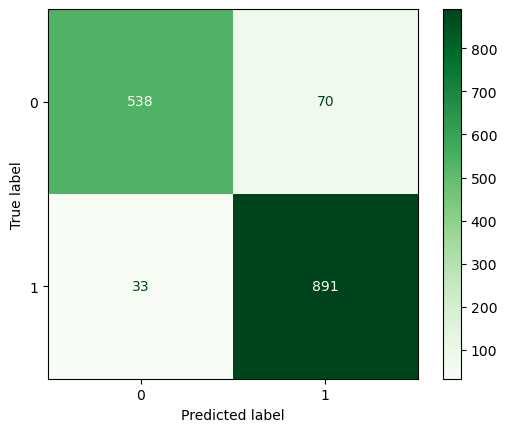

In [232]:
ConfusionMatrixDisplay.from_estimator(gs_logreg, X_test, y_test, cmap='Greens')
plt.xticks([0, 1], ['Marriage', 'Dating']);

In [233]:
# Get predictions
preds = gs_logreg.predict(X_test)

In [234]:
print(classification_report(y_test, preds, digits=4))

              precision    recall  f1-score   support

           0     0.9422    0.8849    0.9126       608
           1     0.9272    0.9643    0.9454       924

    accuracy                         0.9328      1532
   macro avg     0.9347    0.9246    0.9290      1532
weighted avg     0.9331    0.9328    0.9324      1532



# Fitting a random forest
## on posts' texts

In [235]:
rf = RandomForestClassifier(random_state = 1906)

In [236]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1906,
 'verbose': 0,
 'warm_start': False}

In [237]:
X = date_marry['self_text']
y = date_marry['subreddit']

cvec = CountVectorizer()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1906)
X_train = cvec.fit_transform(X_train)
X_test = cvec.transform(X_test)

In [238]:
X_train.shape

(5743, 18102)

In [239]:
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 20, 30, 40]
}

In [240]:
gs = GridSearchCV(rf, rf_params, n_jobs = 4)
gs.fit(X_train, y_train)

/Users/gabrielafichtner/anaconda3/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(estimator=RandomForestClassifier(random_state=1906), n_jobs=4,
             param_grid={'max_depth': [None, 20, 30, 40],
                         'n_estimators': [100, 200, 300]})

In [241]:
gs.best_params_

{'max_depth': None, 'n_estimators': 300}

In [242]:
gs.score(X_test, y_test)

0.9159268929503916

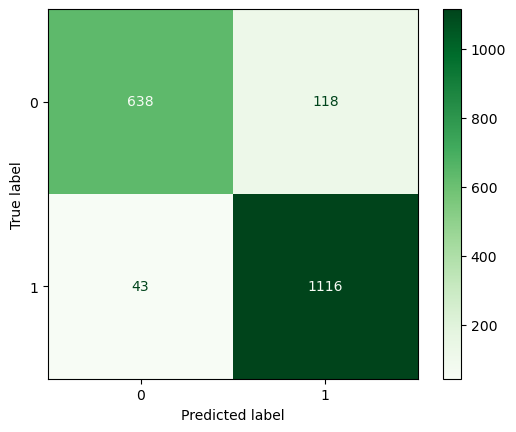

In [243]:
ConfusionMatrixDisplay.from_estimator(gs, X_test, y_test, cmap='Greens')
plt.xticks([0, 1], ['Marriage', 'Dating']);

The lighter squares show that random forest with default parameters performed worse than the logistic regression model, since logistic regression model had smaller numbers in the lighter squares

In [253]:
rf = RandomForestClassifier(random_state = 1906)

In [254]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1906,
 'verbose': 0,
 'warm_start': False}

In [259]:
X = date_marry['self_text']
y = date_marry['subreddit']

cvec = CountVectorizer(stop_words=['wife', 'husband'])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1906)
X_train = cvec.fit_transform(X_train)
X_test = cvec.transform(X_test)

In [260]:
X_train.shape

(5743, 18100)

In [261]:
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=1906)

In [263]:
rf.score(X_test, y_test)

0.8720626631853786

In [ ]:
ConfusionMatrixDisplay.from_estimator(gs, X_test, y_test, cmap='Greens')
plt.xticks([0, 1], ['Marriage', 'Dating']);